In [1]:
import warnings
import importlib
import numpy as np
import pandas as pd
import seaborn as sns
from astropy import units as u
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.optimize import curve_fit,  fsolve, minimize
from io import BytesIO
import sympy as smp
from astropy.table import Table
import astropy.units as u
from astropy.coordinates import SkyCoord
from skimage.measure import EllipseModel
from astroquery.gaia import Gaia
from scipy.signal import convolve2d
from skimage.measure import label as ConnectRegion
from scipy.ndimage import gaussian_filter

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
warnings.filterwarnings('ignore')
import ztfidr
import galaxy_phot as glp

sample = ztfidr.get_sample()
host_data = ztfidr.io.get_host_data()

gaia_map_10 = pd.read_csv('csv_files/gaia_brick10_map.csv', index_col=0)

conds1 = (sample.data['redshift'] > 0 ) & (sample.data['redshift'] < 0.2) 
conds2 = np.intersect1d(host_data.index, sample.data.index)
data = host_data[['host_ra', 'host_dec']].loc[conds2].dropna()[conds1]
targets = data.index

In [74]:
importlib.reload(glp)
tbm = ['ZTF20acwmpsj', 'ZTF19acmvrsw', 'ZTF19acrddcz', 'ZTF19ackjmge',
        'ZTF18aahfzea', 'ZTF20aaummmc', 'ZTF19acymzwh']

In [75]:
sn_name = tbm[0]
gd = glp.galaxy_decomp(sn_name, verbose=True, mask=False, size=300, source='query', catalog='ztf')
print(gd.gobj['g'].brick)
print(gd.gobj['r'].brick)

ZTF20acwmpsj 122.9103268050622 -2.33007092691192 0.051820000000000005 z_gal
ZTF20acwmpsj 122.9103268050622 -2.33007092691192 0.051820000000000005 z_gal
dr10 300 300
dr10 300 300
{'brickname': '1228m022', 'psfsize': 1.3729864, 'psfdepth': 24.193823, 'galdepth': 23.841957, 'sky': 4.2325715e-05, 'sky_mag': 30.372461120246662}
{'brickname': '1228m022', 'psfsize': 1.2083585, 'psfdepth': 23.64038, 'galdepth': 23.33105, 'sky': 4.7471854e-05, 'sky_mag': 30.297752135334708}


In [76]:
ra, dec = gd.gobj['g'].gal['host']
coord = SkyCoord(ra=ra, dec=dec, unit=(u.degree, u.degree), frame='icrs')

size = u.Quantity(gd.image['g'].shape[0] * 0.262/3600, u.deg)
r = Gaia.query_object_async(coordinate=coord, width=size, height=size)
masks_gaia = r[['ra', 'dec']]
masks_gaia['radius'] = 15

INFO: Query finished. [astroquery.utils.tap.core]


(<AxesSubplot:>, <AxesSubplot:>)

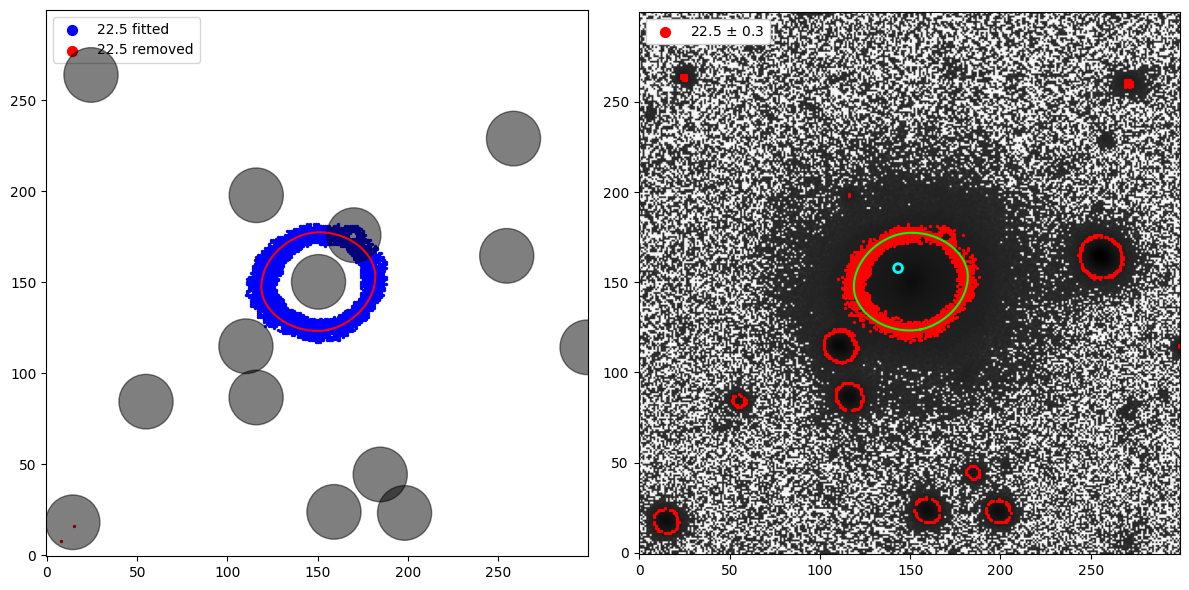

In [77]:
iso, band = 22.5, 'g'
gd.contour_fit(iso, mask=[], band=band)
gd.plot_fit([iso], band=band, width=0.3, mask=mask_data, zoom=False)

In [78]:
def prep_px(iso, wi):
    kernal3 = np.array([[ 0,  1,  1],
                        [ -1,  0,  1],
                        [-1,  -1,  0,]])

    kernal_ = 1/(kernal3 + iso)
    kernal_unit = kernal_ / np.sum(kernal_)
    convolve_1 = convolve2d(gd.image['g'], kernal_unit, mode='same')
    convolve_2 = convolve2d(convolve_1, kernal_unit[::-1], mode='same')

    convolve_2[:5,:] = 0
    convolve_2[-5:,:] = 0
    convolve_2[:,:5] = 0
    convolve_2[:,-5:] = 0

    contour = np.stack(np.where((convolve_2.T > iso-wi) & (convolve_2.T < iso+wi)))

    binary_image = np.zeros_like(gd.image['g'], dtype=np.uint8)
    binary_image[contour[0], contour[1]] = 1
    connect_ = ConnectRegion(binary_image, connectivity=2, background=0)
    region_count = np.asarray(np.unique(connect_, return_counts=True)).T[1:].T
    return region_count, connect_


def get_pixels(region, connect): 
    return np.stack(np.where(connect == region))

def super_ellipse_fitter(data):
    ell = EllipseModel()
    ell.estimate(data)
    if ell.params is None:
        return np.zeros(4), np.ones(4)*np.inf, (0,0)
    xc, yc, a, b, pa = ell.params
    x, y = data.T
    r = np.sqrt((x-xc)**2 + (y-yc)**2)
    phi = np.arctan2(y-yc, x-xc)
    out_pars = curve_fit(gd.super_ellipse, phi, r, p0=[a, b, pa, 2], maxfev=5000)
    return out_pars[0], np.sqrt(np.diag(out_pars[1])), (xc, yc)

(0.0, 300.0)

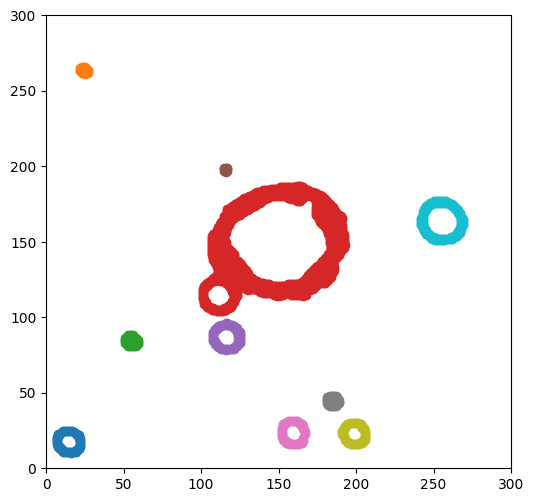

In [79]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
count_r, connect = prep_px(23, 0.35)
for i in range(1, len(count_r.T)):
    data = np.stack(np.where(connect == i)).T
    ax.plot(data.T[0], data.T[1], marker='o', linestyle='none')
ax.set_ylim([0, 300])
ax.set_xlim([0, 300])
# gd.patch_super_ellipse(pars, center, ax, 'lime')

(<AxesSubplot:>, <AxesSubplot:>)

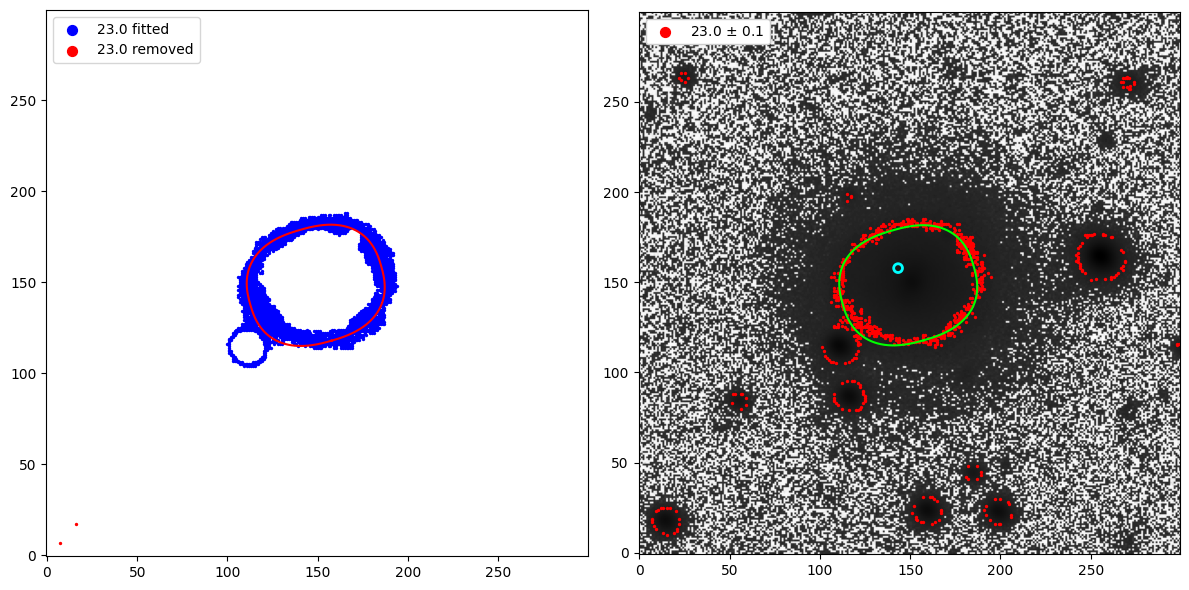

In [80]:
mask_data= masks_gaia.to_pandas().values
iso, band = 23, 'g'
gd.contour_fit(iso, mask=[], band=band)
gd.plot_fit([iso], band=band, width=0.1, zoom=False)

In [81]:
gd.main_run()

g-24.0
g-23.0
g-22.0
g-21.0
g-20.0
g-19.0
g-18.0
r-23.0
r-22.0
r-21.0
r-20.0
r-19.0


In [82]:
bd = glp.BDdecomp(sn_name, gd)
bd.main_BD(spokes=12, mode=0)

One componenet, BIC: -2551.08, RSS: 7.93, fitted parameters: 7
Two componenet, BIC: -3027.11, RSS: 3.36, fitted parameters: 13


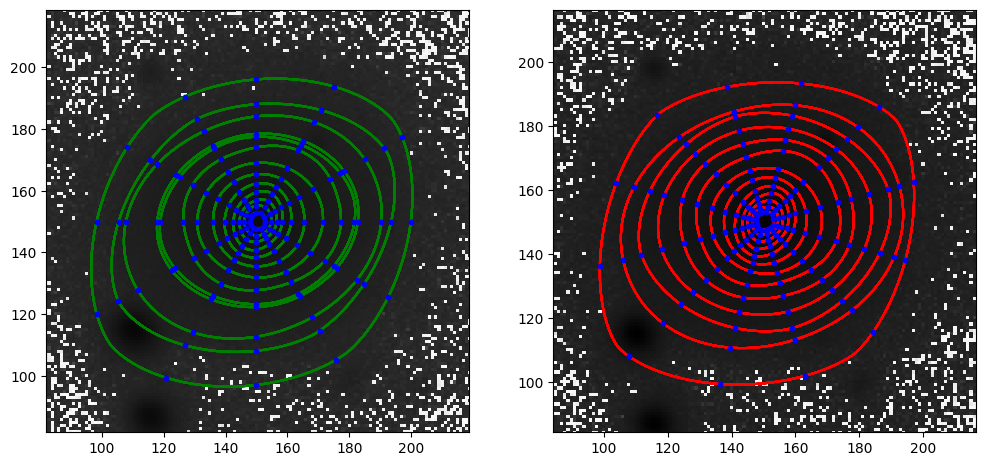

In [83]:
fig, ax = bd.plot_gal_iso(spokes=12)

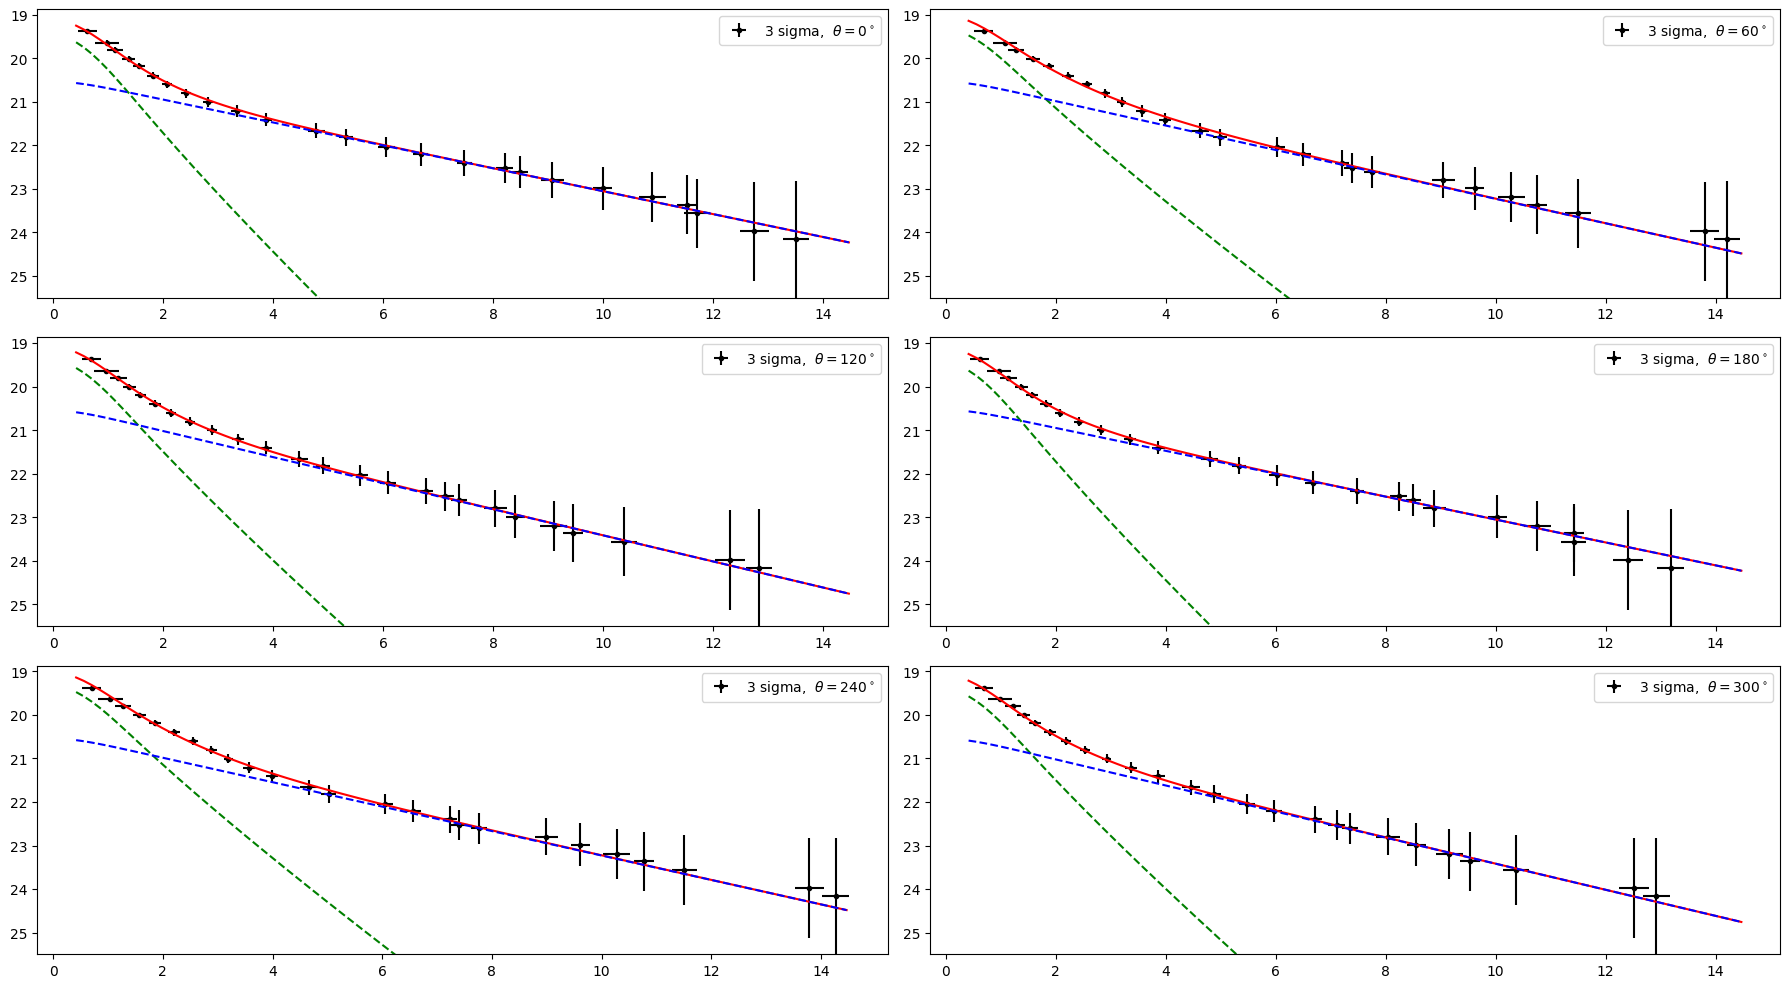

In [84]:
bd.plot_spokes(band='g', sigma=3, n_model=2)

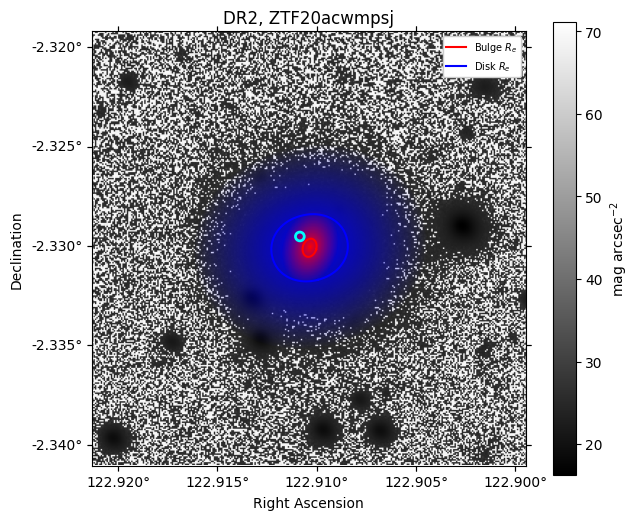

In [85]:
bd.plot_SB_profile(band='g', n_model=2)

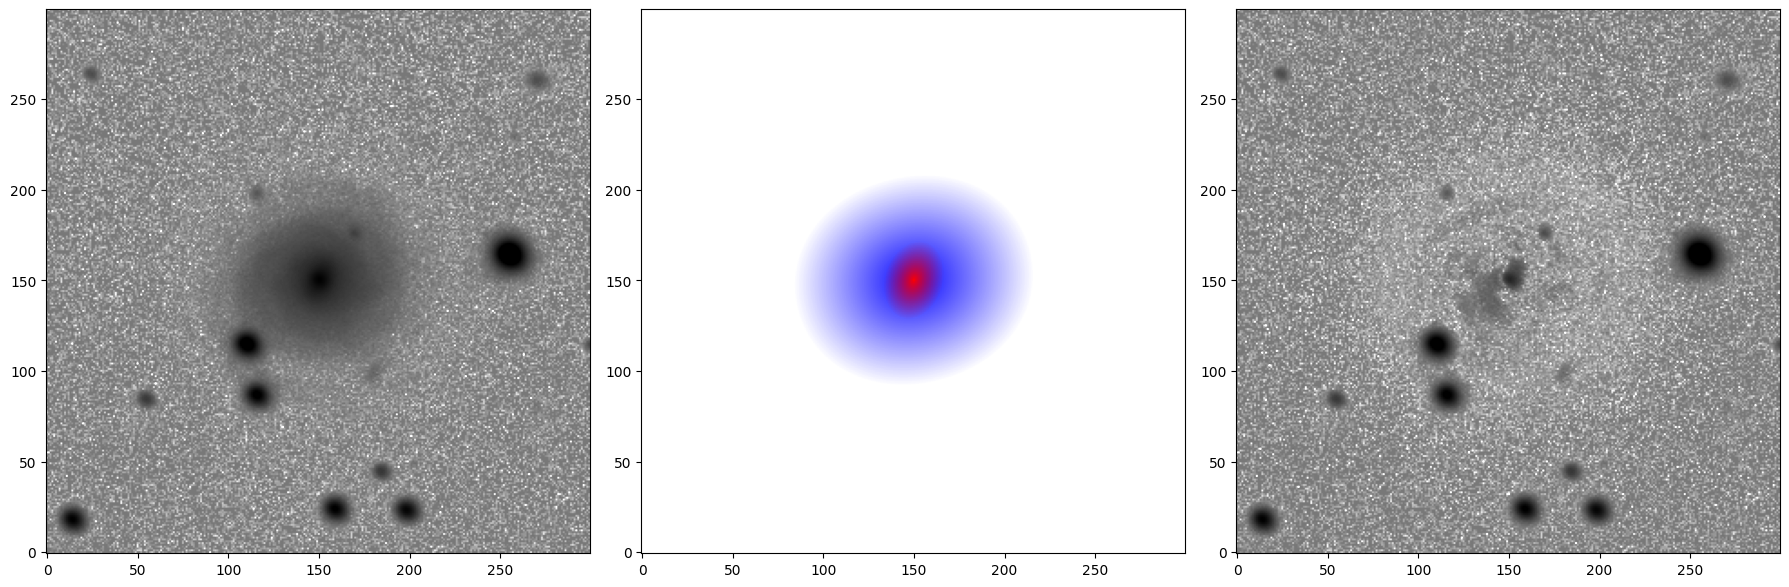

In [86]:
bd.plot_SB_profile(band='g', subtarct=True, n_model=2)